In [1]:
import sys
import os
import json
import networkx as nx

# Since we are in a sub-package, ensure that the top-level package is on the Python path
sys.path.append(os.path.abspath(os.path.join('..', '..')))

# Now we can import modules from python_fbasimport networkx as nx
from python_fbas.fbas import QSet, FBAS


We start with a simple example: given a FBAS, find the smallest parameter p such that, with high probability, an Erdos-Renyi graph on the FBAS's nodes will satisfy the failure assumptions of all the nodes.

In [2]:
# Let's load an example FBAS:
with open('../../tests/test_data/top_tier.json', 'r', encoding='utf-8') as f:
    fbas = FBAS.from_json(json.load(f))

Now, for every degree between 1 and the number of nodes minus one, we generate 1000 graphs of expected degree d and record how many satisfy the failure assumptions of the FBAS:

In [3]:
nodes = list(fbas.validators())
num_sat = {} # dict holding the results
# loop over all value of the degree d from 1 to the number of nodes minus one:
for d in range(1, len(nodes)):
    num_sat[d] = 0
    for i in range(1000):
        # Create an Erdos-Renyi graph with expected degree d:
        g = nx.erdos_renyi_graph(len(nodes), d / len(nodes))
        # rename the nodes to the validator names:
        g = nx.relabel_nodes(g, {i: nodes[i] for i in range(len(nodes))})
        # check that the assumptions of every node are satisfied:
        is_sat = True
        for n in nodes:
            qset : QSet = fbas.qset_map[n]
            peers = g.neighbors(n)
            if not qset.blocked(peers):
                is_sat = False
                break
        if is_sat:
            num_sat[d] += 1

In [4]:
# Next we find the degree d for which the probability of the assumptions being satisfied is 0.99:
min_d = 1
while num_sat[min_d] / 1000 < 0.99:
    min_d += 1
print(f'For an expected degree of {min_d}, the probability of the assumptions being satisfied is at least 0.99.')

For an expected degree of 19, the probability of the assumptions being satisfied is at least 0.99.


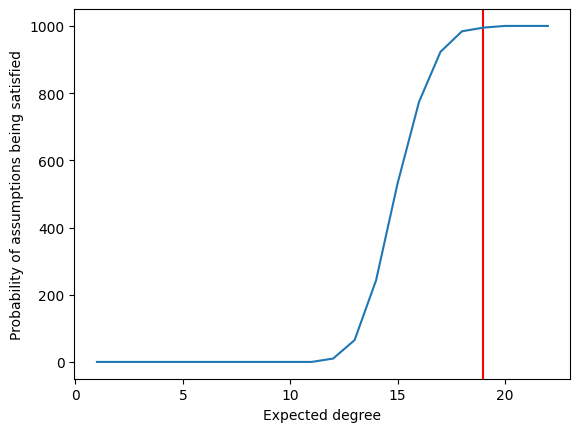

In [5]:
# now plot the results
import matplotlib.pyplot as plt
plt.axvline(x=min_d, color='r')
plt.xlabel('Expected degree')
plt.ylabel('Probability of assumptions being satisfied')
plt.plot(num_sat.keys(), num_sat.values())